# 背景介绍
随着人工智能技术的不断发展，人工智能技术不仅提高了社会生产水平，也提高了人们的生活质量。无论是从自动驾驶领域中的智能视觉到工业领域的智能机器人，还是医疗领域中的智能辅助诊断系统，都是人工智能技术在实际社会场景中的应用落地。计算机视觉中的手写字识别更是应用在了各个领域，比如教育行业的学生试卷主观题自动识别，办公自动化领域的文字批量自动处理，以及公安刑侦领域的手写字迹相似度判别，可见手写字识别的应用广泛且重要。与此同时，由于手写字形态种类多样，尤其是汉字数量大，这些都对手写字识别提出了更高的要求。

本文采用基于多层感知机的神经网络进行手写字识别实验.

# 理论知识
## 多层感知机(Multilayer Perceptron)
在介绍多层感知机之前，我们先介绍多层感知机的基础单元——单个感知机，也称感知机.感知机由两层神经元组成，一层输入层神经元和一层输出层神经元。对于从输入层输入的向量$x$,经过输出层上的线性变换$f(x)=x^Tw+b$后直接输出.
但是由于感知机只有输出层，并没有非线性结构，就算这样多次复合，出来仍是一个线性变换，所以其学习能力非常有限，一般只能学习解决线性可分问题.对于简单的“异或问题”，感知机就已经无能为力了.
【【【【【【图：异或问题】】】】】】】】

也就是说，我们需要更强大的工具。单个感知机的缺点主要来源于他仅有线性结构对于很多非线性问题，我们尝试在每个感知机做完仿射变换之后，再经过一个非线性函数，这样感知机就有了非线性表达能力。

对于更加复杂的问题，研究者们提出将这样的单层感知机(一排感知机)，做多层，这样网络的表达能力就已经非常强大，也就是多层感知机(MLP).
【【【【【【图：多层感知机】】】】】】】】

多层感知机的算法流程如下:
【【【【【【多层感知机流程latex】】】】】】】】



# 模型设计
# 训练技巧
# 数据测试
# 结果分析

In [ ]:
!pip3 install d2l==0.17.1

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

%matplotlib inline
from d2l import torch as d2l
d2l.use_svg_display()

from IPython import display

### 必要函数

In [2]:

class Accumulator:
    """在`n`个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期
    Defined in :numref:`sec_softmax_scratch`"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def accuracy(y_hat, y):
    """计算预测正确的数量
    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度
    Defined in :numref:`sec_softmax_scratch`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [3]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """
    训练模型
    """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.2],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    print("测试集准确率为：",test_acc)

In [4]:
def predict_ch3(net, test_iter, n=6):
    """
    预测标签
    """
    for X, y in test_iter:
        break
    trues = get_mnist_labels(y)
    preds = get_mnist_labels(d2l.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        d2l.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

## 读取数据

In [5]:
def load_data_mnist(batch_size, transform, resize=None):
    """
    下载MNIST数据集，增加了transform参数，用于特征增强，然后将其加载到内存中
    num_workers: 进程数
    
    """
    trans = transform
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

In [6]:
batch_size = 18
transform = transforms.ToTensor()
train_iter, test_iter = load_data_mnist(batch_size, transform)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 数据集介绍
MNIST数据集 [LeCun et al., 1998] 是图像分类中广泛使用的数据集之一.

In [7]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0到1之间
from torch.utils import data
from torchvision import transforms


In [8]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=transforms.ToTensor(), download=True)

本文采用的MNIST数据集是图像分类中广泛使用的数据集之一。MNIST由10个类别的手写数字图像组成，10个类别分别为0、1、2、3、4、5、6、7、8、9的手写数字。每个类别由训练数据集中的6000张图像和测试数据集中的1000张图像组成。因此，训练集和测试集分别包含60000和10000张图像。测试集只用于评估模型性能，不参与模型训练。MNIST数据集图像均为灰度图像，每张输入图像的高度和宽度均为28像素。

In [9]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [10]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

每个输入图像的高度和宽度均为28像素. 数据集由灰度图像组成，其通道数为1.

In [11]:
# 以下函数用于在数字标签索引及其文本名称之间进行转换
def get_mnist_labels(labels):  
    """返回MNIST数据集的文本标签"""
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

In [12]:
import PIL
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'9'}>,
       <AxesSubplot:title={'center':'2'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'6'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'7'}>,
       <AxesSubplot:title={'center':'2'}>,
       <AxesSubplot:title={'center':'8'}>,
       <AxesSubplot:title={'center':'6'}>,
       <AxesSubplot:title={'center':'9'}>], dtype=object)

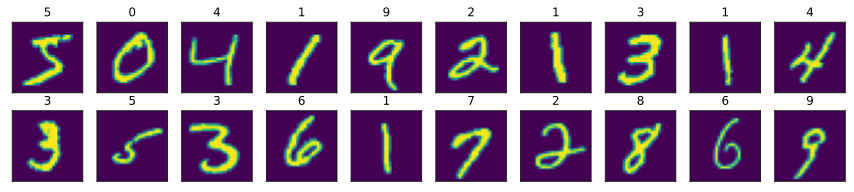

In [13]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=20)))
show_images(X.reshape(20, 28, 28), 2, 10, titles=get_mnist_labels(y))

## 手动实现MLP
### 参数初始化

由于MNIST中的每个图像由$28×28=784$个灰度像素值组成，所有图像共分为10个类别.
忽略像素之间的空间结构,我们可以将每个图像视为具有784个输入特征和10个类的简单分类数据集.

首先，我们将实现一个具有单隐藏层的多层感知机,它包含256个隐藏单元.通常，我们选择2的若干次幂作为层的宽度,因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 800

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [ ]:
# 激活函数
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [ ]:
# 模型
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

In [ ]:
# 交叉熵损失函数
loss = nn.CrossEntropyLoss()

In [ ]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr) #优化器选择SGD
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [44]:
def predict_ch3(net, test_iter, n=6):
    """
    预测标签
    """
    for X, y in test_iter:
        break
    trues = get_mnist_labels(y)
    preds = get_mnist_labels(d2l.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(d2l.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])
    return [trues,preds]

In [ ]:
predict_ch3(net, test_iter)

## 损失评价

In [14]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失
    Defined in :numref:`sec_model_selection`"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = d2l.reshape(y, out.shape)
        l = loss(out, y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

# Baseline
## 模型

In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """
    训练模型
    """
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.2],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    print("测试集准确率为：",test_acc)

测试集准确率为： 0.9503


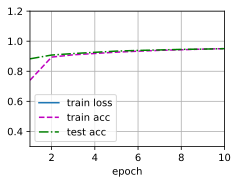

In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

trans = [transforms.ToTensor()]
train_iter, test_iter = load_data_mnist(batch_size, trans)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# Baseline + 图像增强

In [ ]:
from torchvision.transforms import autoaugment, transforms

In [ ]:
net = nn.Sequential(nn.Flatten(),
           nn.Linear(784, 256),
           nn.ReLU(),
           nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

测试集准确率为： 0.9597


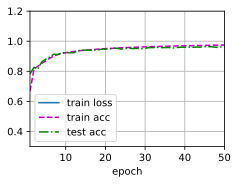

In [ ]:
batch_size, lr, num_epochs = 256, 0.05, 50
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

transform = [transforms.ToTensor(),
       #transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)),
       transforms.RandomHorizontalFlip(),                   
       transforms.Normalize((0.5,), (0.5,))]
train_iter, test_iter = load_data_mnist(batch_size, transform)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 增加训练轮数

In [ ]:
net = nn.Sequential(nn.Flatten(),
           nn.Linear(784,1000),
           nn.ReLU(),
           nn.Linear(1000,2300),
           nn.ReLU(),
           nn.Linear(2300,600),
           nn.ReLU(),
           nn.Linear(600,80),
           nn.ReLU(),
           nn.Linear(80,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

batch_size, lr, num_epochs = 80, 0.03, 100
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)



测试集准确率为： 0.9764


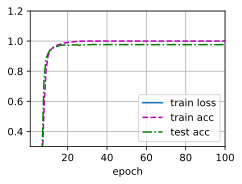

In [ ]:
trans = [transforms.ToTensor()]
train_iter, test_iter = load_data_mnist(batch_size, trans)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 多层网络

## dropout网络

In [33]:
net = nn.Sequential(nn.Flatten(),
           nn.Linear(784,800),
           nn.ReLU(),
           nn.Linear(800,256),
           nn.Dropout(p=0.2),
           nn.Linear(256,32),
           nn.ReLU(),
           nn.Linear(32,10),
           )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

batch_size, lr, num_epochs = 128, 0.05, 20
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)



测试集准确率为： 0.9738


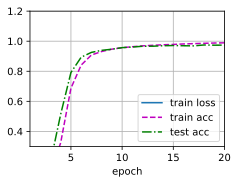

In [34]:
trans = [transforms.ToTensor()]
train_iter, test_iter = load_data_mnist(batch_size, trans)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

测试集准确率为： 0.9778


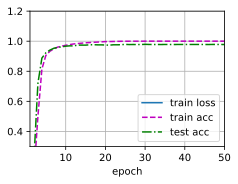

In [ ]:
trans = [transforms.ToTensor()]
train_iter, test_iter = load_data_mnist(batch_size, trans)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 更换激活函数

In [24]:
net = nn.Sequential(nn.Flatten(),
           nn.Linear(784,256),
           nn.ReLU(),
           nn.Linear(256,64),
           nn.ReLU(),
           nn.Linear(64,32),
           nn.ReLU(),
           nn.Linear(32,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

batch_size, lr, num_epochs = 100, 0.05, 20
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

测试集准确率为： 0.9511


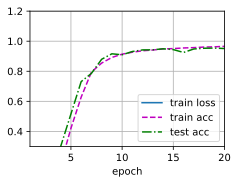

In [25]:
trans = [transforms.ToTensor(),
     #transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.)),
     transforms.RandomHorizontalFlip(),                   
     transforms.Normalize((0.5,), (0.5,))]
train_iter, test_iter = load_data_mnist(batch_size, trans)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [12]:
def load_data_test(batch_size, transform, resize=None):
    """
    下载MNIST数据集，增加了transform参数，用于特征增强，然后将其加载到内存中
    num_workers: 进程数
    
    """
    trans = transform
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_test = torchvision.datasets.MNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=4))

In [36]:
trans = [transforms.ToTensor()]
test = load_data_test(batch_size, trans, resize=None)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


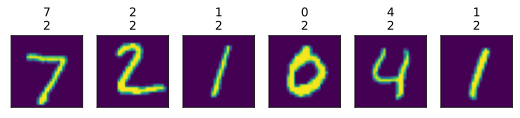

In [45]:
A = predict_ch3(net, test, n=6) 